In [44]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
# Import custom data generation models from the mfpi folder
import sys
sys.path.append("../")
from mfpi import data_gen_models as data

## Data generating model

We generate data from a toy model with 10 explanatory variables and a qualitative label for each sample, which is designed to mimic "heteroschedasticity" in a classification setting.
More precisely, the first variable controls the "noise level" in the label: small values of $X_0$ mean that all labels are more or less equally likely; large values of $X_0$ mean that one label is much more likely than the others (which one is determined by the other features).
To clarify, we visualize below the distribution of the true label probabilities (for one value of the label) as a function of $X_0$, which here can take only two possible values for simplicity. 

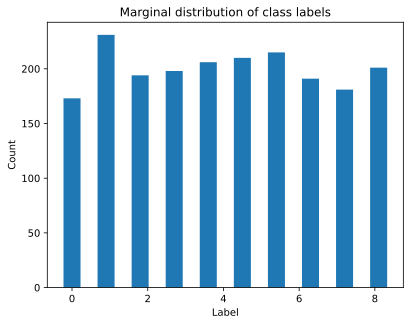

In [46]:
# Set a random seed for reproducibility
np.random.seed(2024)

# Pre-defined model
p = 10                                                 # Number of features
K = 10                                                 # Number of possible labels
data_model = data.Model_Class2(K,p)                    # Data generating model

# Sample data
n = 2000                                               # Number of data samples
X_data = data_model.sample_X(n)                        # Generate the data features
Y_data = data_model.sample_Y(X_data)                   # Generate the data labels conditional on the features

# Sample test data
n_test = 1000                                          # Number of test samples
X_test = data_model.sample_X(n_test)                   # Generate independent test data
Y_test = data_model.sample_Y(X_test)

# Plot the marginal distribution of the class labels
plt.hist(Y_data, bins=K, rwidth=0.5, align="left")
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Marginal distribution of class labels")
plt.show()

## Oracle classifier

Let's apply the classification oracle we learnt about during the lecture.

In [47]:
from mfpi import classification

def oracle(pi, alpha, randomize=True):
    prediction_rule = classification.ProbabilityAccumulator(pi)
    S = prediction_rule.predict_sets(alpha, randomize=randomize)
    return S

# Compute true class probabilities for every sample
pi = data_model.compute_prob(X_test)

# Nominal coverage: 1-alpha 
alpha = 0.1

# Oracle prediction sets
S_oracle = oracle(pi, alpha)                  

In [48]:
S_oracle

[array([3]),
 array([9]),
 array([7]),
 array([0, 1, 2, 3]),
 array([6]),
 array([7]),
 array([6]),
 array([3]),
 array([5, 6, 7, 8, 9]),
 array([5, 6, 7, 8]),
 array([9]),
 array([2]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([8]),
 array([9]),
 array([0]),
 array([3]),
 array([2]),
 array([0, 1, 2, 3]),
 array([1]),
 array([0]),
 array([4]),
 array([0]),
 array([6]),
 array([3]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([7]),
 array([6]),
 array([4]),
 array([0, 1, 2, 3, 4]),
 array([1]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([0, 1, 2, 3]),
 array([9]),
 array([5]),
 array([3]),
 array([1]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([0]),
 array([5, 6, 7, 8]),
 array([6]),
 array([4]),
 array([5]),
 array([5]),
 array([0, 1, 2, 3, 4]),
 array([7]),
 array([4]),
 array([0]),
 array([5]),
 array([4]),
 array([7]),
 array([5]),
 array([6]),
 array([5, 6, 7, 8, 9]),
 array([6]),
 array([5, 6, 7, 8]),
 array([2]),
 array([2]),
 array([8])

Now we would like to evaluate the quality of the oracle predictions

In [49]:
def evaluate_predictions(S, X, Y, verbose=True):
    """
    Evaluate performance metrics for a set of classification predictions
    Computes:
    - marginal coverage
    - unbiased estimate of worst-slab coverage
    - average size of sets
    - average size of sets that contain the true Y
    
    Input
    S         : n - long list of prediction sets (each set is a discrete array)
    X         : n x p data matrix of explanatory variables
    Y         : n x 1 vector of response variables
    """
    
    # Estimate worst-slab coverage
    wsc_coverage = classification.wsc_unbiased(X, Y, S)
    
    # Number of samples
    n = len(Y)
    
    # Output placeholder
    marginal_coverage = None
    size = None
    size_cover = None
    
    # Compute marginal coverage
    marginal_coverage = np.mean([Y[i] in S[i] for i in range(n)])
    
    # Compute average size of prediction sets
    size = np.mean([len(S[i]) for i in range(n)])
    
    # Compute average size of prediction sets that contain the true label
    idx_cover = np.where([Y[i] in S[i] for i in range(n)])[0]
    size_cover = np.mean([len(S[i]) for i in idx_cover])
    
    # Print summary
    if verbose:
        print('Marginal coverage       : {:2.3%}'.format(marginal_coverage))
        print('WS conditional coverage : {:2.3%}'.format(wsc_coverage))
        print('Average size            : {:2.3f}'.format(size))
        print('Average size | cover    : {:2.3f}'.format(size_cover))
        
    return marginal_coverage, wsc_coverage, size, size_cover

In [50]:
metrics = evaluate_predictions(S_oracle, X_test, Y_test)

Marginal coverage       : 89.700%
WS conditional coverage : 90.244%
Average size            : 2.502
Average size | cover    : 2.518


## Deep neural network classifier

We will use a deep neural network classifier written in PyTorch.
This model optimizes the cross-entropy loss using stochastic gradient descent.

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [51]:
from mfpi.deep_classification import Net as ClassNet

# Initialize the black-box classifier
black_box = ClassNet(X_data.shape[1], K, dropout=0, learning_rate=0.01,
                     num_epochs=1000, batch_size=256, num_hidden=256, random_state=2023, calibrate=0, verbose=False)

# Fit the black-box classifier
black_box.fit(X_data, Y_data)

# Estimate class probabilities for test points 
pi_hat = black_box.predict_proba(X_test)
# Make point predictions for test data
Y_hat = np.argmax(pi_hat,1)

100%|██████████| 1000/1000 [00:16<00:00, 60.80it/s]


In [52]:
pi_hat

array([[9.9999011e-07, 9.9999011e-07, 1.0004205e-06, ..., 9.9999011e-07,
        9.9999011e-07, 9.9999011e-07],
       [9.9998999e-07, 9.9998999e-07, 9.9998999e-07, ..., 9.9998999e-07,
        4.5481302e-05, 9.9994057e-01],
       [9.9999011e-07, 9.9999011e-07, 9.9999011e-07, ..., 9.6725279e-01,
        1.8134071e-04, 1.0000725e-06],
       ...,
       [9.9998988e-07, 9.9998988e-07, 5.0446296e-01, ..., 8.3096438e-06,
        4.8915032e-01, 6.2968712e-03],
       [9.9999033e-07, 1.0000036e-06, 9.9999022e-01, ..., 9.9998999e-07,
        9.9998999e-07, 9.9998999e-07],
       [9.9999011e-07, 9.9999106e-01, 1.0001155e-06, ..., 9.9999011e-07,
        9.9999011e-07, 9.9999011e-07]], dtype=float32)

In [53]:
Y_hat

array([3, 9, 7, 1, 6, 7, 5, 3, 9, 6, 9, 2, 9, 8, 9, 0, 3, 2, 4, 1, 0, 4,
       0, 6, 3, 9, 6, 6, 4, 3, 1, 3, 5, 1, 8, 5, 4, 1, 1, 1, 9, 6, 5, 5,
       5, 2, 7, 3, 0, 5, 4, 6, 4, 6, 9, 7, 8, 2, 2, 9, 4, 8, 1, 9, 8, 5,
       9, 6, 1, 0, 6, 3, 9, 2, 3, 7, 8, 6, 9, 2, 0, 0, 7, 4, 5, 9, 5, 1,
       7, 0, 1, 7, 2, 5, 9, 5, 3, 8, 1, 3, 4, 0, 9, 5, 2, 1, 9, 3, 8, 6,
       7, 0, 3, 8, 9, 3, 7, 9, 4, 8, 3, 8, 9, 2, 3, 5, 3, 4, 6, 7, 7, 6,
       4, 6, 5, 6, 5, 7, 4, 8, 4, 7, 8, 7, 6, 8, 2, 4, 5, 7, 9, 7, 3, 5,
       3, 7, 6, 1, 2, 0, 9, 4, 1, 4, 7, 9, 9, 9, 0, 5, 8, 1, 0, 3, 3, 0,
       6, 4, 7, 3, 6, 9, 0, 1, 6, 4, 1, 0, 1, 4, 0, 8, 7, 4, 4, 3, 9, 0,
       1, 7, 2, 3, 6, 7, 0, 0, 7, 8, 1, 4, 1, 7, 8, 8, 5, 6, 1, 7, 7, 9,
       0, 4, 5, 2, 2, 0, 8, 8, 7, 6, 2, 7, 0, 0, 6, 1, 3, 3, 1, 6, 1, 5,
       1, 3, 4, 1, 6, 1, 7, 8, 9, 0, 8, 0, 2, 1, 2, 8, 1, 0, 5, 0, 0, 2,
       7, 1, 8, 1, 4, 9, 4, 0, 6, 8, 7, 1, 6, 4, 3, 7, 6, 6, 7, 2, 7, 0,
       0, 9, 2, 5, 6, 6, 6, 1, 7, 5, 6, 4, 1, 5, 5,

We can extract conditional class probability estimates from this black-box model.

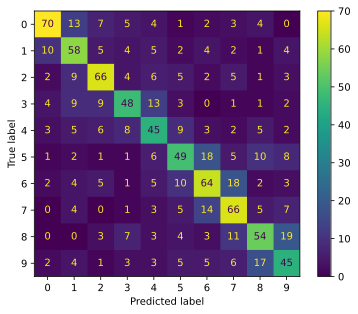

              precision    recall  f1-score   support

           0       0.74      0.64      0.69       109
           1       0.54      0.61      0.57        95
           2       0.64      0.64      0.64       103
           3       0.59      0.53      0.56        90
           4       0.48      0.51      0.50        88
           5       0.53      0.49      0.51       101
           6       0.56      0.56      0.56       114
           7       0.55      0.63      0.59       105
           8       0.54      0.52      0.53       104
           9       0.48      0.49      0.49        91

    accuracy                           0.56      1000
   macro avg       0.57      0.56      0.56      1000
weighted avg       0.57      0.56      0.57      1000



In [54]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Display confusion matrix
cm = confusion_matrix(Y_test, Y_hat)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

# Print classification report
print(classification_report(Y_test, Y_hat))

Let's compare the estimated class probabilities to the true class probabilities.

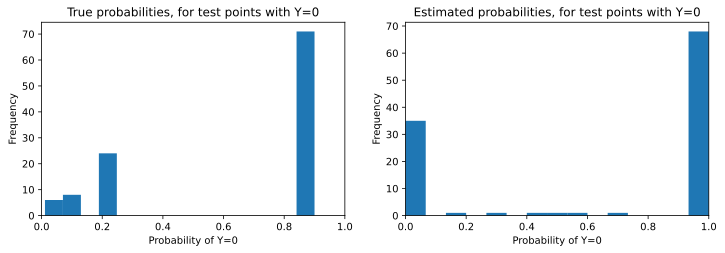

In [55]:
# Compute true conditional probabilities from data generating model
prob_true = data_model.compute_prob(X_test)

# Indices of test points with true label equal to 0
idx_0 = np.where(Y_test==0)[0]

# Compare true and estimated probabilities of class 0
prob_0_true = prob_true[idx_0, 0]
prob_0_hat = pi_hat[idx_0, 0]

# Prepare to make side-to-side plots
plt.figure(figsize=(12,3.5))

plt.subplot(1, 2, 1)
plt.hist(prob_0_true, bins=15)
plt.xlim(0,1)
plt.xlabel("Probability of Y=0")
plt.ylabel("Frequency")
plt.title("True probabilities, for test points with Y=0")

plt.subplot(1, 2, 2)
plt.hist(prob_0_hat, bins=15)
plt.xlim(0,1)
plt.xlabel("Probability of Y=0")
plt.ylabel("Frequency")
plt.title("Estimated probabilities, for test points with Y=0")

plt.show()

Clearly, the black-box classifier is over-confident.

Let's see what happens if we plug these probability estimates into the oracle classification rule.

In [56]:
# Black-box plugin prediction sets
# S_plugin = None
"""TODO: write your code here (1 line)"""
S_plugin = oracle(pi_hat,alpha)

# Evaluate prediction sets
"""TODO: write your code here (1 line)"""
metrics_plugin = evaluate_predictions(S_plugin, X_test, Y_test)

Marginal coverage       : 58.500%
WS conditional coverage : 23.529%
Average size            : 1.110
Average size | cover    : 1.094


## Split-conformal classification

In [57]:
from sklearn.model_selection import train_test_split
from scipy.stats.mstats import mquantiles
from sklearn.neural_network import MLPClassifier

def sc_classification(X, Y, X_test, black_box, alpha):
    """
    Compute split-conformal classification prediction sets.
    Uses neural network as a black box 
    
    Input
    X         : n x p data matrix of explanatory variables
    Y         : n x 1 vector of response variables
    X_test    : n x p test data matrix of explanatory variables
    alpha     : 1 - target coverage level 
    """
    
    # Output placeholder
    S = None
    
    # Split the data into training and calibration sets
    X_train, X_calib, Y_train, Y_calib = train_test_split(X, Y, test_size=0.5, random_state=2023)
    
    # Fit a quantile regression model
    # black_box = MLPClassifier(learning_rate_init = 0.01, max_iter = 1000, hidden_layer_sizes = 64, 
    #                           random_state = 2023)
    black_box.fit(X_train, Y_train)
    
    # Estimate class probabilities for calibration points (store them in a variable called 'pi_hat')
    """TODO: write your code here (1 line)"""
    pi_hat = black_box.predict_proba(X_calib)


    # Define prediction rule with plugin probability estimates
    prediction_rule = classification.ProbabilityAccumulator(pi_hat)
    
    # Generate independent uniform random variables for the calibration data (store them in a variable called 'epsilon')
    n_calib = len(Y_calib)
    """TODO: write your code here (1 line)"""
    epsilon = np.random.uniform(low = 0.0, high = 1.0, size = n_calib)

    
    
    # Compute conformity scores
    scores = prediction_rule.calibrate_scores(Y_calib, epsilon = epsilon)
    
    # Compute suitable empirical quantile of absolute residuals
    """TODO: write your code here (2 lines)"""
    level_adjusted = (1.0-alpha)  * (1+ 1/n_calib)
    Q_hat = mquantiles(scores, prob=level_adjusted)[0]

    # Construct prediction sets for test data
    """TODO: write your code here (2 lines)"""
    pi_hat_test = black_box.predict_proba(X_test)
    S = oracle(pi_hat_test, 1 - Q_hat)
    
    return S

In [58]:
# Desired coverage level (1-alpha)
alpha = 0.1

# Apply split conformal classification
S = sc_classification(X_data, Y_data, X_test, black_box, alpha)

# Evaluate prediction sets
metrics = evaluate_predictions(S, X_test, Y_test)

100%|██████████| 1000/1000 [00:08<00:00, 120.17it/s]


Marginal coverage       : 59.100%
WS conditional coverage : 28.090%
Average size            : 1.082
Average size | cover    : 1.074


## Open-ended exercise

Investigate the effect of the number of training epochs on the overconfidence of the deep neural network model, and on the performance of the conformal prediction sets.